# Fatigue Detection - Results Analysis

Comprehensive analysis and comparison of all trained models:
- CNN_2s, CNN_4s, CNN_8s, CNN_16s, CNN_32s
- CNN_LSTM

**Test Set:** Subject 07 (100,600 Fatigue samples)

**Key Metrics:**
- Cohen's Kappa (primary metric for imbalanced data)
- Precision & Recall
- Confusion Matrix
- Training Curves

## 1. Setup and Configuration

In [1]:
# Import libraries
import numpy as np
import scipy.io as spio
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import (
    confusion_matrix, accuracy_score, f1_score,
    precision_score, recall_score, cohen_kappa_score
)
import os
from pathlib import Path

# Configure plotting
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300

print("Setup complete!")

Setup complete!


## 2. Configuration

In [13]:
# Mount Google Drive to save results
from google.colab import drive
drive.mount('/content/drive')
print("✓ Google Drive mounted")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✓ Google Drive mounted


In [14]:
# ========================================
# CONFIGURATION
# ========================================

# Base paths
BASE_PATH = '/content/drive/MyDrive/microsleep_cursor'  # Local files
RESULTS_PATH = '/content/drive/MyDrive/microsleep_results'  # Test results

# Model list
MODELS = ['CNN_2s', 'CNN_4s', 'CNN_8s', 'CNN_16s', 'CNN_32s', 'CNN_LSTM']

# Output directory for plots
OUTPUT_DIR = '/content/drive/MyDrive/Fatigue_results/analysis_plots'
os.makedirs(OUTPUT_DIR, exist_ok=True)

print(f"Results path: {RESULTS_PATH}")
print(f"Output directory: {OUTPUT_DIR}")
print(f"Models to analyze: {len(MODELS)}")

Results path: /content/drive/MyDrive/microsleep_results
Output directory: /content/drive/MyDrive/Fatigue_results/analysis_plots
Models to analyze: 6


## 3. Load Test Results

In [15]:
print("="*80)
print("Loading Test Results from Google Drive")
print("="*80)

test_results = {}

for model_name in MODELS:
    result_file = f'{RESULTS_PATH}/{model_name}_test_results.mat'

    if os.path.exists(result_file):
        try:
            data = spio.loadmat(result_file)
            test_results[model_name] = {
                'y_true': data['y_true'].flatten(),
                'y_pred': data['y_pred'].flatten(),
                'accuracy': float(data['accuracy']) if 'accuracy' in data else None,
                'f1_score': float(data['f1_score']) if 'f1_score' in data else None,
                'kappa': float(data['kappa']) if 'kappa' in data else None,
                'recall_drowsy': float(data['recall_drowsy']) if 'recall_drowsy' in data else None,
                'precision_drowsy': float(data['precision_drowsy']) if 'precision_drowsy' in data else None,
                'confusion_matrix': data['confusion_matrix'] if 'confusion_matrix' in data else None
            }
            print(f"✓ Loaded: {model_name}")
        except Exception as e:
            print(f"✗ Error loading {model_name}: {e}")
    else:
        print(f"✗ Not found: {model_name}")

print(f"\n✓ Successfully loaded {len(test_results)}/{len(MODELS)} models")

Loading Test Results from Google Drive


/tmp/ipython-input-1923760832.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'accuracy': float(data['accuracy']) if 'accuracy' in data else None,
/tmp/ipython-input-1923760832.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'f1_score': float(data['f1_score']) if 'f1_score' in data else None,
/tmp/ipython-input-1923760832.py:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'kappa': float(data['kappa']) if 'kappa' in data else None,
/tmp/ipython-input-192

✓ Loaded: CNN_2s
✓ Loaded: CNN_4s
✓ Loaded: CNN_8s
✓ Loaded: CNN_16s
✓ Loaded: CNN_32s
✓ Loaded: CNN_LSTM

✓ Successfully loaded 6/6 models


## 4. Load Training History

In [16]:
print("="*80)
print("Loading Training History")
print("="*80)

training_history = {}

for model_name in MODELS:
    if model_name == 'CNN_LSTM':
        history_file = f'{BASE_PATH}/code/CNN_LSTM/predictions.mat'
    else:
        history_file = f'{BASE_PATH}/code/CNN/{model_name}/predictions.mat'

    if os.path.exists(history_file):
        try:
            data = spio.loadmat(history_file)
            training_history[model_name] = {
                'loss_tr': data['loss_tr'].flatten() if 'loss_tr' in data else None,
                'loss_val': data['loss_val'].flatten() if 'loss_val' in data else None,
                'acc_val': data['acc_val'].flatten() if 'acc_val' in data else None,
                'K_val': data['K_val'] if 'K_val' in data else None
            }
            print(f"✓ Loaded history: {model_name} ({len(training_history[model_name]['loss_tr'])} epochs)")
        except Exception as e:
            print(f"✗ Error loading history for {model_name}: {e}")
    else:
        print(f"✗ History not found: {model_name}")

print(f"\n✓ Successfully loaded history for {len(training_history)}/{len(MODELS)} models")

Loading Training History
✓ Loaded history: CNN_2s (9 epochs)
✓ Loaded history: CNN_4s (9 epochs)
✓ Loaded history: CNN_8s (9 epochs)
✓ Loaded history: CNN_16s (9 epochs)
✓ Loaded history: CNN_32s (9 epochs)
✓ Loaded history: CNN_LSTM (9 epochs)

✓ Successfully loaded history for 6/6 models


## 5. Calculate Performance Metrics

In [17]:
print("="*80)
print("Calculating Performance Metrics")
print("="*80)

metrics_summary = []

for model_name, data in test_results.items():
    y_true = data['y_true']
    y_pred = data['y_pred']

    # Calculate metrics
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted')
    precision = precision_score(y_true, y_pred, pos_label=1, zero_division=0)
    recall = recall_score(y_true, y_pred, pos_label=1, zero_division=0)
    kappa = cohen_kappa_score(y_true, y_pred)

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel() if cm.size == 4 else (0, 0, 0, 0)

    # Specificity
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

    metrics_summary.append({
        'Model': model_name,
        'Accuracy': acc,
        'F1-Score': f1,
        'Precision': precision,
        'Recall': recall,
        'Specificity': specificity,
        'Kappa': kappa,
        'TP': int(tp),
        'TN': int(tn),
        'FP': int(fp),
        'FN': int(fn)
    })

    print(f"\n{model_name}:")
    print(f"  Kappa:     {kappa:.4f}")
    print(f"  Precision: {precision:.4f} ({precision*100:.2f}%)")
    print(f"  Recall:    {recall:.4f} ({recall*100:.2f}%)")
    print(f"  TP: {tp:,}, FP: {fp:,}, FN: {fn:,}")

# Create DataFrame
df_metrics = pd.DataFrame(metrics_summary)
df_metrics = df_metrics.sort_values('Kappa', ascending=False)

print("\n" + "="*80)
print("Metrics Summary (sorted by Kappa):")
print("="*80)
print(df_metrics.to_string(index=False))

Calculating Performance Metrics

CNN_2s:
  Kappa:     0.0556
  Precision: 0.0947 (9.47%)
  Recall:    0.0767 (7.67%)
  TP: 7,715, FP: 73,739, FN: 92,885

CNN_4s:
  Kappa:     0.0458
  Precision: 0.1965 (19.65%)
  Recall:    0.0320 (3.20%)
  TP: 3,222, FP: 13,175, FN: 97,378

CNN_8s:
  Kappa:     0.2888
  Precision: 0.5894 (58.94%)
  Recall:    0.2024 (20.24%)
  TP: 20,362, FP: 14,186, FN: 80,238

CNN_16s:
  Kappa:     0.3944
  Precision: 0.5486 (54.86%)
  Recall:    0.3273 (32.73%)
  TP: 32,927, FP: 27,096, FN: 67,673

CNN_32s:
  Kappa:     0.3552
  Precision: 0.5312 (53.12%)
  Recall:    0.2848 (28.48%)
  TP: 28,648, FP: 25,282, FN: 71,952

CNN_LSTM:
  Kappa:     0.0079
  Precision: 0.0418 (4.18%)
  Recall:    0.0455 (4.55%)
  TP: 4,582, FP: 105,027, FN: 96,018

Metrics Summary (sorted by Kappa):
   Model  Accuracy  F1-Score  Precision   Recall  Specificity    Kappa    TP      TN     FP    FN
 CNN_16s  0.967467  0.963474   0.548573 0.327306     0.990366 0.394359 32927 2785304  27096 6

## 6. Visualization: Performance Bar Charts

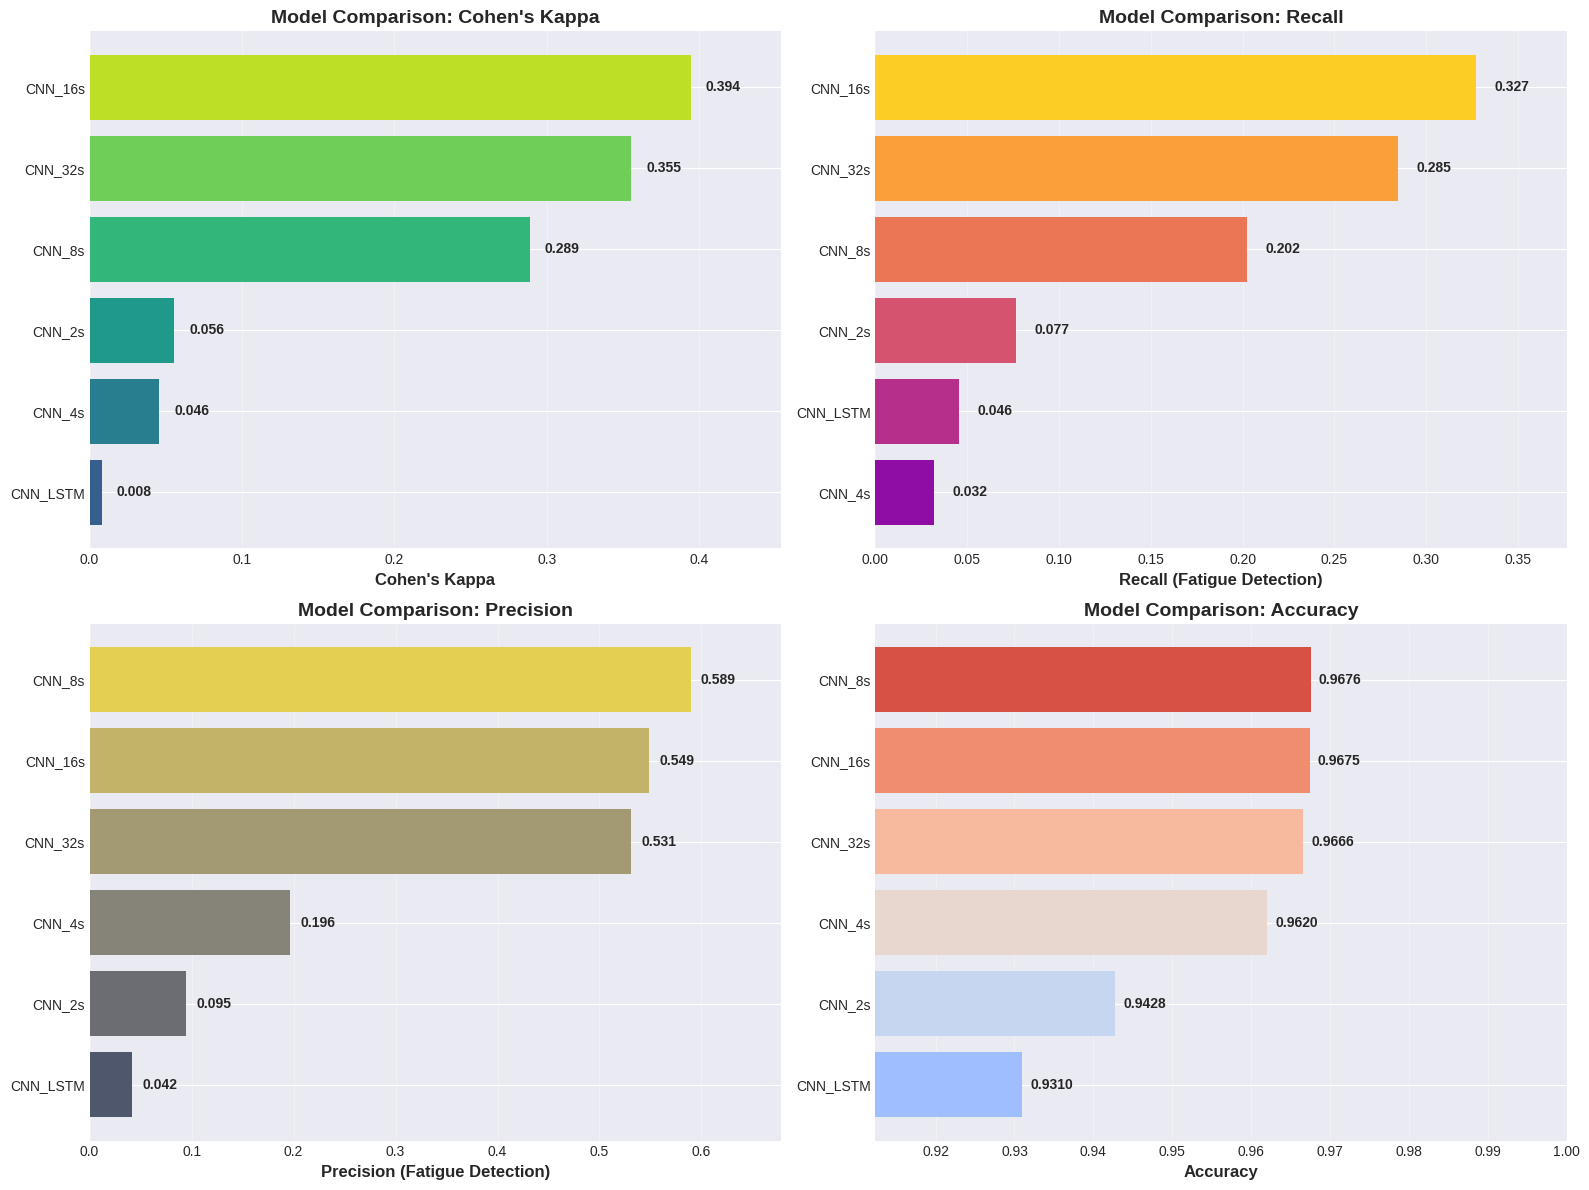


✓ Plot saved: /content/drive/MyDrive/Fatigue_results/analysis_plots/performance_comparison.png


In [18]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Kappa comparison
ax1 = axes[0, 0]
df_sorted = df_metrics.sort_values('Kappa', ascending=True)
colors = plt.cm.viridis(np.linspace(0.3, 0.9, len(df_sorted)))
bars1 = ax1.barh(df_sorted['Model'], df_sorted['Kappa'], color=colors)
ax1.set_xlabel("Cohen's Kappa", fontsize=12, fontweight='bold')
ax1.set_title("Model Comparison: Cohen's Kappa", fontsize=14, fontweight='bold')
ax1.set_xlim([0, max(df_sorted['Kappa']) * 1.15])
for i, v in enumerate(df_sorted['Kappa']):
    ax1.text(v + 0.01, i, f'{v:.3f}', va='center', fontsize=10, fontweight='bold')
ax1.grid(axis='x', alpha=0.3)

# Plot 2: Recall comparison
ax2 = axes[0, 1]
df_sorted = df_metrics.sort_values('Recall', ascending=True)
colors = plt.cm.plasma(np.linspace(0.3, 0.9, len(df_sorted)))
bars2 = ax2.barh(df_sorted['Model'], df_sorted['Recall'], color=colors)
ax2.set_xlabel('Recall (Fatigue Detection)', fontsize=12, fontweight='bold')
ax2.set_title('Model Comparison: Recall', fontsize=14, fontweight='bold')
ax2.set_xlim([0, max(df_sorted['Recall']) * 1.15])
for i, v in enumerate(df_sorted['Recall']):
    ax2.text(v + 0.01, i, f'{v:.3f}', va='center', fontsize=10, fontweight='bold')
ax2.grid(axis='x', alpha=0.3)

# Plot 3: Precision comparison
ax3 = axes[1, 0]
df_sorted = df_metrics.sort_values('Precision', ascending=True)
colors = plt.cm.cividis(np.linspace(0.3, 0.9, len(df_sorted)))
bars3 = ax3.barh(df_sorted['Model'], df_sorted['Precision'], color=colors)
ax3.set_xlabel('Precision (Fatigue Detection)', fontsize=12, fontweight='bold')
ax3.set_title('Model Comparison: Precision', fontsize=14, fontweight='bold')
ax3.set_xlim([0, max(df_sorted['Precision']) * 1.15])
for i, v in enumerate(df_sorted['Precision']):
    ax3.text(v + 0.01, i, f'{v:.3f}', va='center', fontsize=10, fontweight='bold')
ax3.grid(axis='x', alpha=0.3)

# Plot 4: Accuracy comparison
ax4 = axes[1, 1]
df_sorted = df_metrics.sort_values('Accuracy', ascending=True)
colors = plt.cm.coolwarm(np.linspace(0.3, 0.9, len(df_sorted)))
bars4 = ax4.barh(df_sorted['Model'], df_sorted['Accuracy'], color=colors)
ax4.set_xlabel('Accuracy', fontsize=12, fontweight='bold')
ax4.set_title('Model Comparison: Accuracy', fontsize=14, fontweight='bold')
ax4.set_xlim([min(df_sorted['Accuracy']) * 0.98, 1.0])
for i, v in enumerate(df_sorted['Accuracy']):
    ax4.text(v + 0.001, i, f'{v:.4f}', va='center', fontsize=10, fontweight='bold')
ax4.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/performance_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ Plot saved: {OUTPUT_DIR}/performance_comparison.png")

## 7. Visualization: Precision-Recall Tradeoff

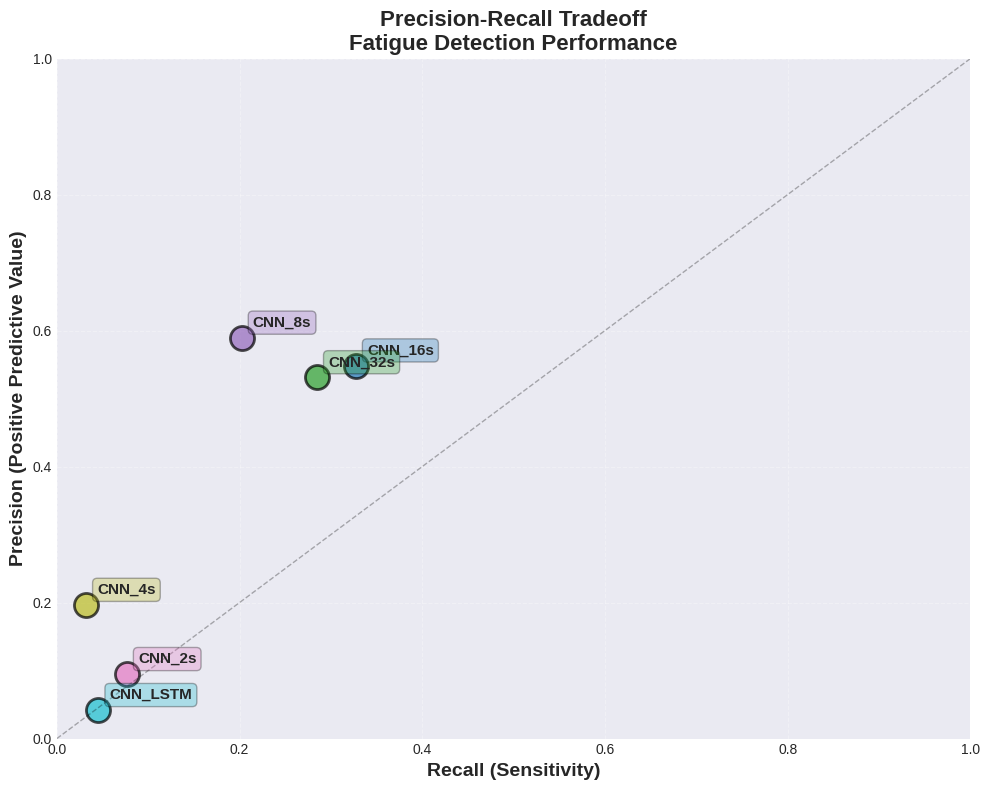


✓ Plot saved: /content/drive/MyDrive/Fatigue_results/analysis_plots/precision_recall_tradeoff.png


In [19]:
fig, ax = plt.subplots(figsize=(10, 8))

# Create scatter plot
colors = plt.cm.tab10(np.linspace(0, 1, len(df_metrics)))
for idx, (_, row) in enumerate(df_metrics.iterrows()):
    ax.scatter(row['Recall'], row['Precision'], s=300, alpha=0.7,
              color=colors[idx], edgecolors='black', linewidth=2)
    ax.annotate(row['Model'], (row['Recall'], row['Precision']),
               xytext=(8, 8), textcoords='offset points',
               fontsize=11, fontweight='bold',
               bbox=dict(boxstyle='round,pad=0.3', facecolor=colors[idx], alpha=0.3))

ax.set_xlabel('Recall (Sensitivity)', fontsize=14, fontweight='bold')
ax.set_ylabel('Precision (Positive Predictive Value)', fontsize=14, fontweight='bold')
ax.set_title('Precision-Recall Tradeoff\nFatigue Detection Performance',
            fontsize=16, fontweight='bold')
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.grid(True, alpha=0.3, linestyle='--')

# Add diagonal reference line
ax.plot([0, 1], [0, 1], 'k--', alpha=0.3, linewidth=1)

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/precision_recall_tradeoff.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ Plot saved: {OUTPUT_DIR}/precision_recall_tradeoff.png")